In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers import Dense, GlobalAveragePooling3D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers.convolutional_recurrent import ConvLSTM2D
from tqdm import tqdm

import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

In [2]:
# check gpu mode

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
/device:GPU:0


In [3]:
# image specification
img_rows, img_cols = 64, 64

# Training data
# variable to store dataset
X_tr = []

In [4]:
data_path = os.path.join("/data")
gestures_path = os.listdir(data_path)

for gesture_dir_path in gestures_path:
    dir_list = os.listdir(os.path.join(data_path, gesture_dir_path))

    counter = 0

    for dir in tqdm(dir_list):
        frames_list = sorted(os.listdir(os.path.join(data_path, gesture_dir_path, dir)))

        frames = []
        img_depth = 0

        for img in frames_list:
            if img_depth < 16:
                img_path = os.path.join(os.path.join(data_path, gesture_dir_path, dir), img)
                frame = cv2.imread(img_path)
                frame = cv2.resize(frame, (img_rows, img_cols), interpolation=cv2.INTER_AREA)
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(gray)
                img_depth = img_depth + 1
            else:
                break

        input_img = np.array(frames)
        #ipyplot.plot_images(frames, max_images=32, img_width=80)

        ipt = np.rollaxis(np.rollaxis(input_img, 2, 0), 2, 0)
        ipt = np.rollaxis(ipt, 2, 0)

        X_tr.append(ipt)

        counter = counter + 1
        if counter >= 300:
            break

    print(gesture_dir_path, "loaded")

num_samples = len(X_tr)
print(num_samples)
print(ipt.shape)

  0%|          | 5/4348 [00:00<01:27, 49.39it/s]

No gesture loaded


  0%|          | 5/4219 [00:00<01:27, 48.26it/s]

Sliding Two Fingers Down loaded


  0%|          | 6/4162 [00:00<01:16, 54.08it/s]

Sliding Two Fingers Up loaded


  0%|          | 6/4084 [00:00<01:16, 52.98it/s]

Swiping Left loaded


  7%|▋         | 299/4084 [00:05<01:09, 54.26it/s]

Swiping Right loaded
1500
(16, 64, 64, 3)


In [5]:
# convert the frames into array
X_tr_array = np.array(X_tr)

num_samples = len(X_tr_array)
print(num_samples)

1500


In [6]:
label = np.ones((num_samples,), dtype = int)
label[0:300] = 0
label[300:600] = 1
label[600:900] = 2
label[900:1200] = 3
label[1200:1500] = 4

In [7]:
img_depth = 16
train_data = [X_tr_array, label]

(X_train, y_train) = (train_data[0],train_data[1])
print('X_Train shape:', X_train.shape)

train_set = np.zeros((num_samples, img_depth, img_cols, img_rows, 3))

for h in range(num_samples):
    train_set[h][:][:][:][:]=X_train[h,:,:,:]


patch_size = 16    # img_depth or number of frames used for each video

print(train_set.shape, 'train samples')

X_Train shape: (1500, 16, 64, 64, 3)
(1500, 16, 64, 64, 3) train samples


In [8]:
nb_classes = 5

In [9]:
Y_train = np_utils.to_categorical(y_train, nb_classes)

In [10]:
# preparing data

train_set = train_set.astype('float32')
print(np.mean(train_set))
train_set -= np.mean(train_set)
print(np.max(train_set))
train_set /= np.max(train_set)

109.063896
145.9361


In [11]:
# Define model
weight_decay = 0.00005
from keras.regularizers import l2

model = Sequential()
model.add(Conv3D(16,(3,3,3),
                        input_shape=(patch_size, img_cols, img_rows, 3),
                        activation='relu'))
model.add(Conv3D(16,(3,3,3), strides=(1,1,1),padding='same',
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False,
                    name='Conv3D_2a_a', activation = 'relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))


model.add(Conv3D(32,(3,3,3), strides=(1,1,1),padding='same',
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False,
                    name='Conv3D_2b_a', activation = 'relu'))
model.add(Conv3D(32,(3,3,3), strides=(1,1,1),padding='same',
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False,
                    name='Conv3D_2b_b', activation = 'relu'))
model.add(MaxPooling3D(pool_size=(1, 2,2)))


model.add(Conv3D(64,(3,3,3), strides=(1,1,1),padding='same',
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False,
                    name='Conv3D_2c_a', activation = 'relu'))
model.add(Conv3D(64,(3,3,3), strides=(1,1,1),padding='same',
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False,
                    name='Conv3D_2c_b', activation = 'relu'))
model.add(Conv3D(64,(3,3,3), strides=(1,1,1),padding='same',
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False,
                    name='Conv3D_2c_c', activation = 'relu'))
model.add(MaxPooling3D(pool_size=(1, 2,2)))


model.add(Conv3D(128,(3,3,3), strides=(1,1,1),padding='same',
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False,
                    name='Conv3D_2d_a', activation = 'relu'))
model.add(Conv3D(128,(3,3,3), strides=(1,1,1),padding='same',
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False,
                    name='Conv3D_2d_b', activation = 'relu'))
model.add(Conv3D(128,(3,3,3), strides=(1,1,1),padding='same',
                    dilation_rate=(1,1,1), kernel_initializer='he_normal',
                    kernel_regularizer=l2(weight_decay), use_bias=False,
                    name='Conv3D_2d_c', activation = 'relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))






model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='gatedclstm2d_2'))

model.add(ConvLSTM2D(filters=64, kernel_size=(3,3),
                  strides=(1,1),padding='same',
                      kernel_initializer='he_normal', recurrent_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay), recurrent_regularizer=l2(weight_decay),
                      return_sequences=True, name='gatedclstm2d_3'))






model.add(GlobalAveragePooling3D())
model.add(Dropout(0.5))
model.add(Dense(nb_classes,kernel_initializer='normal'))

model.add(Activation('softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 14, 62, 62, 16)    1312      
_________________________________________________________________
Conv3D_2a_a (Conv3D)         (None, 14, 62, 62, 16)    6912      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 31, 31, 16)     0         
_________________________________________________________________
Conv3D_2b_a (Conv3D)         (None, 7, 31, 31, 32)     13824     
_________________________________________________________________
Conv3D_2b_b (Conv3D)         (None, 7, 31, 31, 32)     27648     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 15, 15, 32)     0         
_________________________________________________________________
Conv3D_2c_a (Conv3D)         (None, 7, 15, 15, 64)     5

In [13]:
import os

print(os.getcwd())
save_dir = os.path.join(os.getcwd(),'model')
model_name = "model"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)


checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy',
                            save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)

/home/shysa/PycharmProjects/test2


In [14]:
model.compile(loss='categorical_crossentropy',
              #optimizer=sgd,
              #optimizer=ada,
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [15]:
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(train_set, Y_train, test_size=0.2, random_state=20)

In [16]:
batch_size = 32
nb_epoch = 300

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.05,
                               cooldown=0, patience=10, min_lr=0.005/(2^4),verbose=1)
hist = model.fit(
    X_train_new,
    y_train_new,
    validation_data=(X_val_new,y_val_new),
    batch_size=batch_size,
    epochs = nb_epoch,
    shuffle=True,
    callbacks=[checkpoint, lr_reducer]
    )

Epoch 1/300
38/38 [==============================] - 37s 686ms/step - loss: 1.8289 - accuracy: 0.1990 - val_loss: 1.8320 - val_accuracy: 0.1667

Epoch 00001: val_accuracy improved from -inf to 0.16667, saving model to /home/shysa/PycharmProjects/test2/model/model
INFO:tensorflow:Assets written to: /home/shysa/PycharmProjects/test2/model/model/assets
Epoch 2/300
38/38 [==============================] - 24s 620ms/step - loss: 1.8284 - accuracy: 0.2050 - val_loss: 1.8336 - val_accuracy: 0.1700

Epoch 00002: val_accuracy improved from 0.16667 to 0.17000, saving model to /home/shysa/PycharmProjects/test2/model/model
INFO:tensorflow:Assets written to: /home/shysa/PycharmProjects/test2/model/model/assets
Epoch 3/300
38/38 [==============================] - 24s 622ms/step - loss: 1.8287 - accuracy: 0.2197 - val_loss: 1.8353 - val_accuracy: 0.1700

Epoch 00003: val_accuracy did not improve from 0.17000
Epoch 4/300
38/38 [==============================] - 24s 622ms/step - loss: 1.8289 - accuracy


Epoch 00037: val_accuracy did not improve from 0.20000
Epoch 38/300
38/38 [==============================] - 24s 624ms/step - loss: 1.8270 - accuracy: 0.2057 - val_loss: 1.8342 - val_accuracy: 0.2000

Epoch 00038: val_accuracy did not improve from 0.20000
Epoch 39/300
38/38 [==============================] - 24s 623ms/step - loss: 1.8265 - accuracy: 0.2189 - val_loss: 1.8341 - val_accuracy: 0.1900

Epoch 00039: val_accuracy did not improve from 0.20000
Epoch 40/300
38/38 [==============================] - 24s 624ms/step - loss: 1.8247 - accuracy: 0.2061 - val_loss: 1.8344 - val_accuracy: 0.1767

Epoch 00040: val_accuracy did not improve from 0.20000
Epoch 41/300
38/38 [==============================] - 24s 624ms/step - loss: 1.8256 - accuracy: 0.2038 - val_loss: 1.8343 - val_accuracy: 0.1767

Epoch 00041: val_accuracy did not improve from 0.20000

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0008333333333333334.
Epoch 42/300
38/38 [==============================] - 24s 6

38/38 [==============================] - 24s 626ms/step - loss: 1.8219 - accuracy: 0.2418 - val_loss: 1.8297 - val_accuracy: 0.1800

Epoch 00076: val_accuracy did not improve from 0.20667
Epoch 77/300
38/38 [==============================] - 24s 624ms/step - loss: 1.8217 - accuracy: 0.2213 - val_loss: 1.8305 - val_accuracy: 0.1800

Epoch 00077: val_accuracy did not improve from 0.20667
Epoch 78/300
38/38 [==============================] - 24s 628ms/step - loss: 1.8205 - accuracy: 0.2533 - val_loss: 1.8313 - val_accuracy: 0.1733

Epoch 00078: val_accuracy did not improve from 0.20667
Epoch 79/300
38/38 [==============================] - 24s 631ms/step - loss: 1.8194 - accuracy: 0.2469 - val_loss: 1.8308 - val_accuracy: 0.1733

Epoch 00079: val_accuracy did not improve from 0.20667
Epoch 80/300
38/38 [==============================] - 24s 630ms/step - loss: 1.8198 - accuracy: 0.2545 - val_loss: 1.8289 - val_accuracy: 0.1767

Epoch 00080: val_accuracy did not improve from 0.20667
Epoch 81

Epoch 110/300
38/38 [==============================] - 23s 618ms/step - loss: 1.6788 - accuracy: 0.3670 - val_loss: 1.6763 - val_accuracy: 0.4200

Epoch 00110: val_accuracy improved from 0.38333 to 0.42000, saving model to /home/shysa/PycharmProjects/test2/model/model
INFO:tensorflow:Assets written to: /home/shysa/PycharmProjects/test2/model/model/assets
Epoch 111/300
38/38 [==============================] - 23s 619ms/step - loss: 1.6644 - accuracy: 0.3879 - val_loss: 1.6747 - val_accuracy: 0.4100

Epoch 00111: val_accuracy did not improve from 0.42000
Epoch 112/300
38/38 [==============================] - 24s 620ms/step - loss: 1.6358 - accuracy: 0.4316 - val_loss: 1.6335 - val_accuracy: 0.4500

Epoch 00112: val_accuracy improved from 0.42000 to 0.45000, saving model to /home/shysa/PycharmProjects/test2/model/model
INFO:tensorflow:Assets written to: /home/shysa/PycharmProjects/test2/model/model/assets
Epoch 113/300
38/38 [==============================] - 24s 619ms/step - loss: 1.6295

38/38 [==============================] - 23s 618ms/step - loss: 1.1731 - accuracy: 0.6692 - val_loss: 1.1891 - val_accuracy: 0.7367

Epoch 00139: val_accuracy did not improve from 0.74667
Epoch 140/300
38/38 [==============================] - 23s 619ms/step - loss: 1.1456 - accuracy: 0.6857 - val_loss: 1.2019 - val_accuracy: 0.7067

Epoch 00140: val_accuracy did not improve from 0.74667
Epoch 141/300
38/38 [==============================] - 23s 618ms/step - loss: 1.1642 - accuracy: 0.6884 - val_loss: 1.1704 - val_accuracy: 0.7433

Epoch 00141: val_accuracy did not improve from 0.74667
Epoch 142/300
38/38 [==============================] - 23s 618ms/step - loss: 1.1343 - accuracy: 0.7093 - val_loss: 1.1786 - val_accuracy: 0.7200

Epoch 00142: val_accuracy did not improve from 0.74667
Epoch 143/300
38/38 [==============================] - 23s 618ms/step - loss: 1.1252 - accuracy: 0.7194 - val_loss: 1.1445 - val_accuracy: 0.7333

Epoch 00143: val_accuracy did not improve from 0.74667
Epoc

38/38 [==============================] - 23s 618ms/step - loss: 0.7602 - accuracy: 0.8475 - val_loss: 0.8510 - val_accuracy: 0.7900

Epoch 00175: val_accuracy did not improve from 0.80000
Epoch 176/300
38/38 [==============================] - 23s 618ms/step - loss: 0.7907 - accuracy: 0.8147 - val_loss: 0.8780 - val_accuracy: 0.7833

Epoch 00176: val_accuracy did not improve from 0.80000
Epoch 177/300
38/38 [==============================] - 23s 618ms/step - loss: 0.7746 - accuracy: 0.8268 - val_loss: 0.8180 - val_accuracy: 0.7867

Epoch 00177: val_accuracy did not improve from 0.80000
Epoch 178/300
38/38 [==============================] - 23s 618ms/step - loss: 0.7902 - accuracy: 0.8136 - val_loss: 0.8522 - val_accuracy: 0.7933

Epoch 00178: val_accuracy did not improve from 0.80000
Epoch 179/300
38/38 [==============================] - 23s 618ms/step - loss: 0.7837 - accuracy: 0.8115 - val_loss: 0.8435 - val_accuracy: 0.7900

Epoch 00179: val_accuracy did not improve from 0.80000
Epoc

38/38 [==============================] - 23s 618ms/step - loss: 0.5169 - accuracy: 0.9084 - val_loss: 0.7539 - val_accuracy: 0.8067

Epoch 00212: val_accuracy did not improve from 0.82667
Epoch 213/300
38/38 [==============================] - 23s 619ms/step - loss: 0.4769 - accuracy: 0.9308 - val_loss: 0.7872 - val_accuracy: 0.8067

Epoch 00213: val_accuracy did not improve from 0.82667

Epoch 00213: ReduceLROnPlateau reducing learning rate to 0.0008333333333333334.
Epoch 214/300
38/38 [==============================] - 23s 618ms/step - loss: 0.4708 - accuracy: 0.9380 - val_loss: 0.8094 - val_accuracy: 0.8000

Epoch 00214: val_accuracy did not improve from 0.82667
Epoch 215/300
38/38 [==============================] - 23s 618ms/step - loss: 0.5230 - accuracy: 0.9140 - val_loss: 0.7710 - val_accuracy: 0.8300

Epoch 00215: val_accuracy improved from 0.82667 to 0.83000, saving model to /home/shysa/PycharmProjects/test2/model/model
INFO:tensorflow:Assets written to: /home/shysa/PycharmProj

38/38 [==============================] - 23s 618ms/step - loss: 0.3306 - accuracy: 0.9751 - val_loss: 0.9165 - val_accuracy: 0.8100

Epoch 00249: val_accuracy did not improve from 0.84667
Epoch 250/300
38/38 [==============================] - 23s 618ms/step - loss: 0.3578 - accuracy: 0.9642 - val_loss: 0.8953 - val_accuracy: 0.8067

Epoch 00250: val_accuracy did not improve from 0.84667

Epoch 00250: ReduceLROnPlateau reducing learning rate to 0.0008333333333333334.
Epoch 251/300
38/38 [==============================] - 23s 618ms/step - loss: 0.3474 - accuracy: 0.9686 - val_loss: 0.9389 - val_accuracy: 0.7800

Epoch 00251: val_accuracy did not improve from 0.84667
Epoch 252/300
38/38 [==============================] - 23s 618ms/step - loss: 0.3552 - accuracy: 0.9621 - val_loss: 0.8860 - val_accuracy: 0.8133

Epoch 00252: val_accuracy did not improve from 0.84667
Epoch 253/300
38/38 [==============================] - 23s 618ms/step - loss: 0.3253 - accuracy: 0.9716 - val_loss: 1.1409 - 

38/38 [==============================] - 23s 618ms/step - loss: 0.2603 - accuracy: 0.9937 - val_loss: 1.0337 - val_accuracy: 0.7933

Epoch 00287: val_accuracy did not improve from 0.85000
Epoch 288/300
38/38 [==============================] - 23s 618ms/step - loss: 0.2750 - accuracy: 0.9872 - val_loss: 1.0278 - val_accuracy: 0.7967

Epoch 00288: val_accuracy did not improve from 0.85000
Epoch 289/300
38/38 [==============================] - 23s 618ms/step - loss: 0.2836 - accuracy: 0.9848 - val_loss: 0.9840 - val_accuracy: 0.8133

Epoch 00289: val_accuracy did not improve from 0.85000
Epoch 290/300
38/38 [==============================] - 23s 618ms/step - loss: 0.2867 - accuracy: 0.9875 - val_loss: 1.0898 - val_accuracy: 0.7600

Epoch 00290: val_accuracy did not improve from 0.85000

Epoch 00290: ReduceLROnPlateau reducing learning rate to 0.0008333333333333334.
Epoch 291/300
38/38 [==============================] - 23s 618ms/step - loss: 0.2791 - accuracy: 0.9816 - val_loss: 1.0100 - 

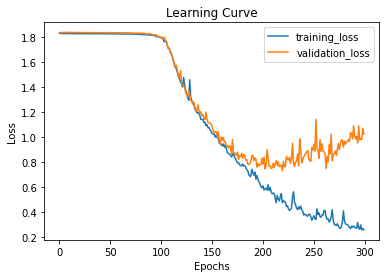

In [17]:
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()


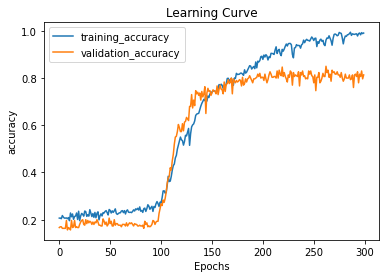

In [18]:
training_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

plt.plot(training_acc, label="training_accuracy")
plt.plot(val_acc, label="validation_accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

### Metrics

In [19]:
from keras.models import load_model

check_model = load_model(model_path)

In [20]:
test_pred = check_model.predict(X_train_new[50:70])
result = np.argmax(test_pred, axis =1)
print(result)

[4 4 4 0 3 4 0 1 4 1 2 1 1 0 0 0 4 2 2 3]


In [21]:
img_array = X_train_new[50]

In [22]:
from sklearn.metrics import confusion_matrix

met = confusion_matrix(np.argmax(y_val_new, axis=1), np.argmax(check_model.predict(X_val_new), axis=1))
print(met)

[[48  0  3  0  0]
 [ 0 67  5  3  2]
 [ 1  9 45  2  4]
 [ 2  1  3 42  1]
 [ 1  0  1  7 53]]


In [23]:
import itertools
def confusion_matrix_plot(cm, classes,
                          title='Normalized Confusion Matrix',
                          normalize=True,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

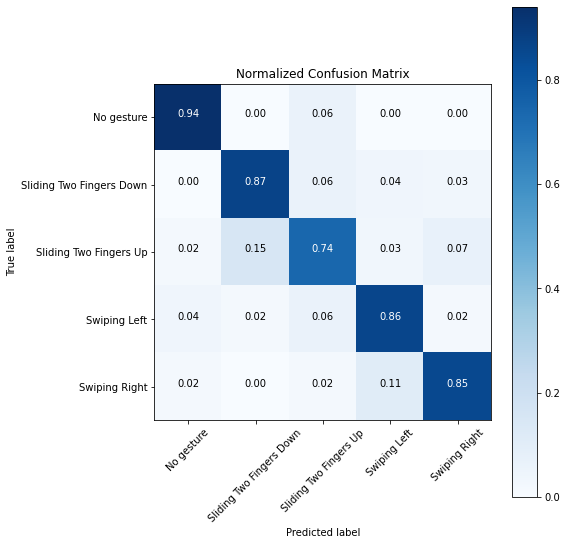

In [25]:
confusion_matrix_plot(met, classes=['No gesture', 'Sliding Two Fingers Down', 'Sliding Two Fingers Up',
                                    'Swiping Left', 'Swiping Right'])

In [ ]:
scores = check_model.evaluate(X_val_new, y_val_new, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
